# Scan MERRA-2 atmospheric properties during one month
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation January 12 2017
- update January 12 2016

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One month of MERRA-2 predictions of the dataset  tavg1_2d_csp_Nx_M2T1NXCSP. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [10]:
# SELECT MONTH IN 2016
MONTH_NAME='11' # select october

In [11]:
# SELECT OBSERVATORY
OBS_NAME='ohp'

In [12]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/DAGORETBACK/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM/2016"
HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/tavg1_2d_csp_Nx_M2T1NXCSP"

In [13]:
path=HDFEOS_ZOO_DIR

### Here I describe the content of the input files

In [14]:
DATA_TAG=['ISCCPCLDFRC','MDSH2OPATH','MDSICEPATH','MDSOPTHCKH2O','MDSOPTHCKICE','MDSOPTHCKTTL']

In [15]:
DATA_TITLE=['ISCCP Cloud area fraction',
            'MODIS H2O path',
            'MODIS ice path',
            'MODIS H2O optical thickness',
            'MODIS ice optical thickness',
            'MODIS total optical thickness'
           ]

In [16]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [17]:
# The selected data field
DATA_NAME =  'tavg1_2d_csp_Nx_M2T1NXCSP'   # 

In [18]:
pandas_filename='MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'.csv'

In [19]:
fits_filename='MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME +'.fits'

In [20]:
# 6 output files for figures
figfile_odh2omean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_odh2omean'+'.jpg'
figfile_odicemean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_odicemean'+'.jpg'
figfile_odtotmean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_odtotmean'+'.jpg'

figfile_thh2omean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_thh2omean'+'.jpg'
figfile_thicemean='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_thicemean'+'.jpg'

figfile_cldfrac='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_cldfrac'+'.jpg'

### Select where in the world

In [21]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [22]:
loc

(5.71222222222, 43.9316666667, 650.0)

### 2.2) Getting the list of the files
------------------------------

In [23]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [24]:
nc4_files[:5]

['MERRA2_400.tavg1_2d_csp_Nx.20160101.nc4',
 'MERRA2_400.tavg1_2d_csp_Nx.20160102.nc4',
 'MERRA2_400.tavg1_2d_csp_Nx.20160103.nc4',
 'MERRA2_400.tavg1_2d_csp_Nx.20160104.nc4',
 'MERRA2_400.tavg1_2d_csp_Nx.20160105.nc4']

### 2.3) Select files of a given month

In [25]:
keysel_filename='^MERRA2_400.tavg1_2d_csp_Nx.2016{}.*'.format(MONTH_NAME)

In [26]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.tavg1_2d_csp_Nx.201611.*


In [27]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [28]:
nc4_files2

array(['MERRA2_400.tavg1_2d_csp_Nx.20161101.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161102.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161103.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161104.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161105.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161106.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161107.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161108.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161109.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161110.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161111.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161112.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161113.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161114.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161115.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161116.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161117.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161118.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161119.nc4',
       'MERRA2_400.tavg1_2d_csp_Nx.20161120.nc4',


### 2.4) Sort files by increasing time

In [29]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [30]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [31]:
clf_timeseries=[] # example of time series for cloud fraction for test
ts0=[]  # intermediate data series
ts1=[]
ts2=[]
ts3=[]
ts4=[]
ts5=[]

df_tavg1_2d_csp_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print 'start_time = ', start_time
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
    # isccp cloud area fraction
    (m_clf_data,m_clf_unit,m_clf_longname)=merra2.GetGeoRefData(file,DATA_TAG[0]) # 3D array : time x longitude x latitude  
    clf=m_clf_data[:,sel_lat,sel_long]
    ts = pd.Series(clf, index=time_rng)
    clf_timeseries.append(ts)
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)
        elif index==3:
            ts3 = pd.Series(dt, index=time_rng)
        elif index ==4:
            ts4 = pd.Series(dt, index=time_rng)
        elif index ==5:
            ts5 = pd.Series(dt, index=time_rng)
            
        #clf_timeseries.append(ts)
        # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2,
                       DATA_TAG[3]: ts3,
                       DATA_TAG[4]: ts4,
                       DATA_TAG[5]: ts5 }, index=time_rng)
    df_tavg1_2d_csp_Nx.append(df)  
    

start_time =  ['2016-11-01 00:30:00']
start_time =  ['2016-11-02 00:30:00']
start_time =  ['2016-11-03 00:30:00']
start_time =  ['2016-11-04 00:30:00']
start_time =  ['2016-11-05 00:30:00']
start_time =  ['2016-11-06 00:30:00']
start_time =  ['2016-11-07 00:30:00']
start_time =  ['2016-11-08 00:30:00']
start_time =  ['2016-11-09 00:30:00']
start_time =  ['2016-11-10 00:30:00']
start_time =  ['2016-11-11 00:30:00']
start_time =  ['2016-11-12 00:30:00']
start_time =  ['2016-11-13 00:30:00']
start_time =  ['2016-11-14 00:30:00']
start_time =  ['2016-11-15 00:30:00']
start_time =  ['2016-11-16 00:30:00']
start_time =  ['2016-11-17 00:30:00']
start_time =  ['2016-11-18 00:30:00']
start_time =  ['2016-11-19 00:30:00']
start_time =  ['2016-11-20 00:30:00']
start_time =  ['2016-11-21 00:30:00']
start_time =  ['2016-11-22 00:30:00']
start_time =  ['2016-11-23 00:30:00']
start_time =  ['2016-11-24 00:30:00']
start_time =  ['2016-11-25 00:30:00']
start_time =  ['2016-11-26 00:30:00']
start_time =

### Concatenation

In [32]:
result = pd.concat(clf_timeseries)

In [33]:
df_tavg1_2d_csp_Nx=pd.concat(df_tavg1_2d_csp_Nx)

In [34]:
df_tavg1_2d_csp_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2016-11-01 00:30:00 to 2016-11-30 23:30:00
Data columns (total 6 columns):
ISCCPCLDFRC     322 non-null float32
MDSH2OPATH      322 non-null float32
MDSICEPATH      322 non-null float32
MDSOPTHCKH2O    238 non-null float32
MDSOPTHCKICE    152 non-null float32
MDSOPTHCKTTL    274 non-null float32
dtypes: float32(6)
memory usage: 22.5 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [35]:
result = pd.concat(clf_timeseries)

In [36]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_tavg1_2d_csp_Nx[DATA_TAG[index]].plot(lw=3,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in 2016/{}".format(DATA_TITLE[index],OBS_NAME,MONTH_NAME)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) Cloud fraction

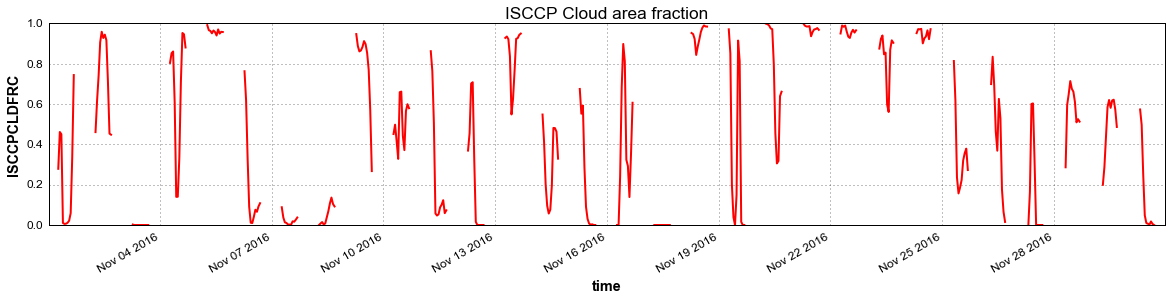

In [37]:
plt.figure(figsize=(20,4))
result.plot(grid=True,lw=2,color='red')
plt.xlabel('time')
plt.ylabel(DATA_TAG[0])
plt.title(DATA_TITLE[0])

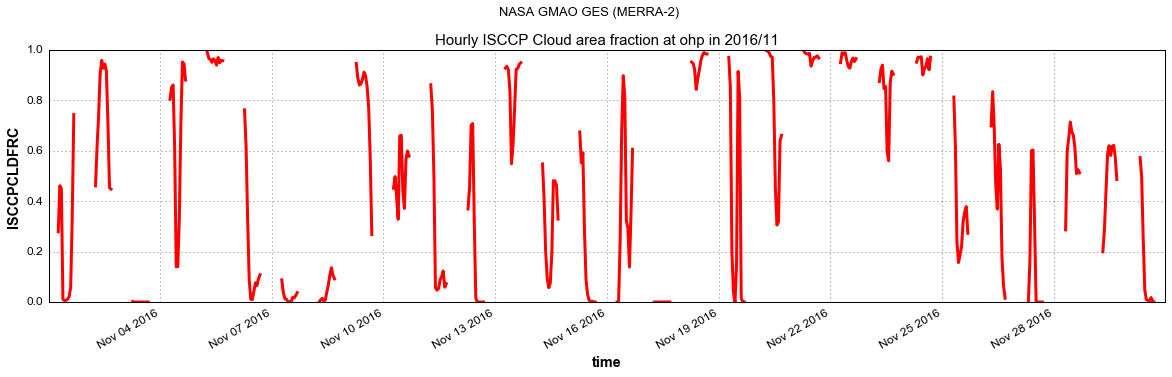

In [38]:
PlotTimeSeries(0,figfile_cldfrac)

###  4.2)  MODIS H2O Path Mean

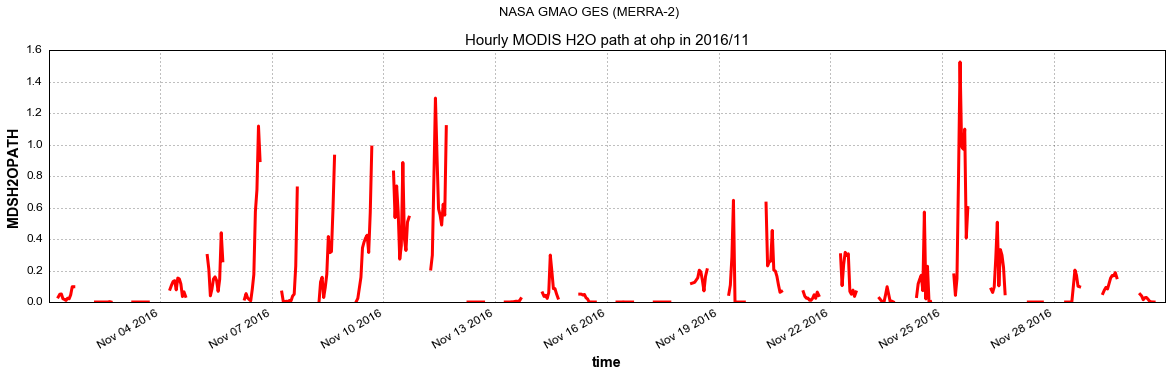

In [39]:
PlotTimeSeries(1,figfile_thh2omean)

### 4.3) MODIS Ice Path Mean

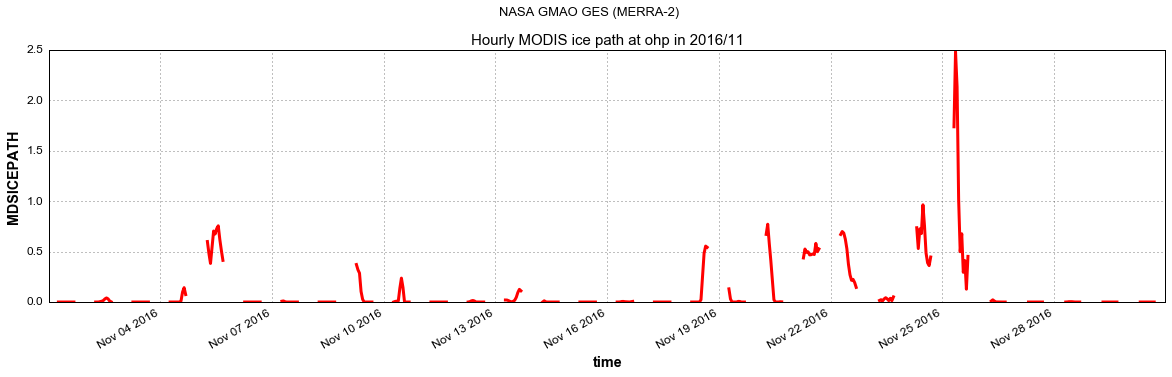

In [40]:
PlotTimeSeries(2,figfile_thicemean)

### 4.4) MODIS H2O Optical Depth

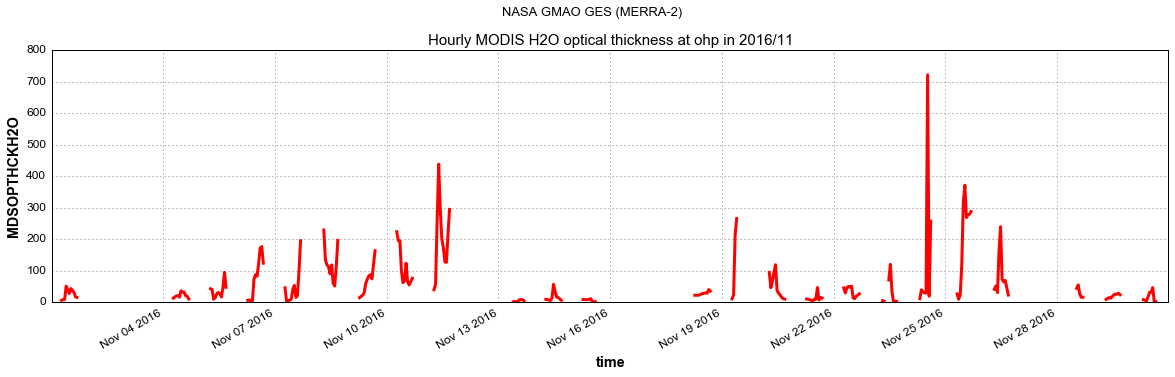

In [41]:
PlotTimeSeries(3,figfile_odh2omean)

### 4.5) MODIS Ice Optical Depth

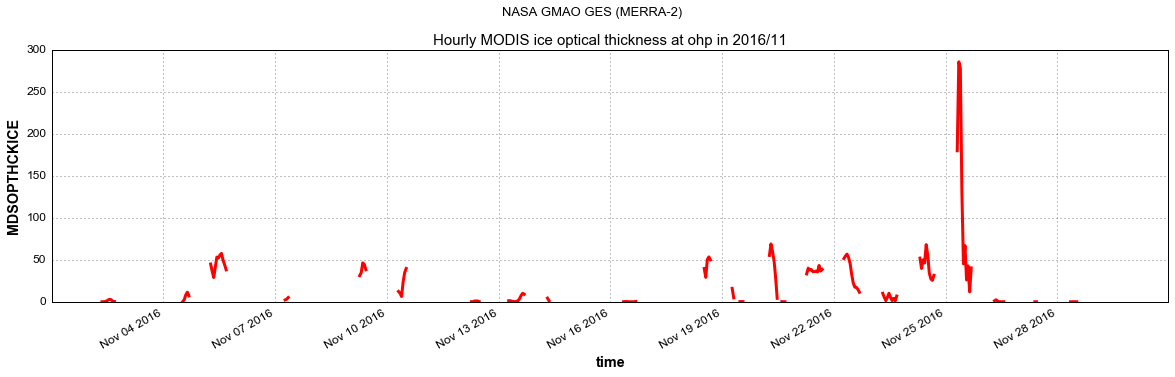

In [42]:
PlotTimeSeries(4,figfile_odicemean)

### 4.6) MODIS Total Optical Depth

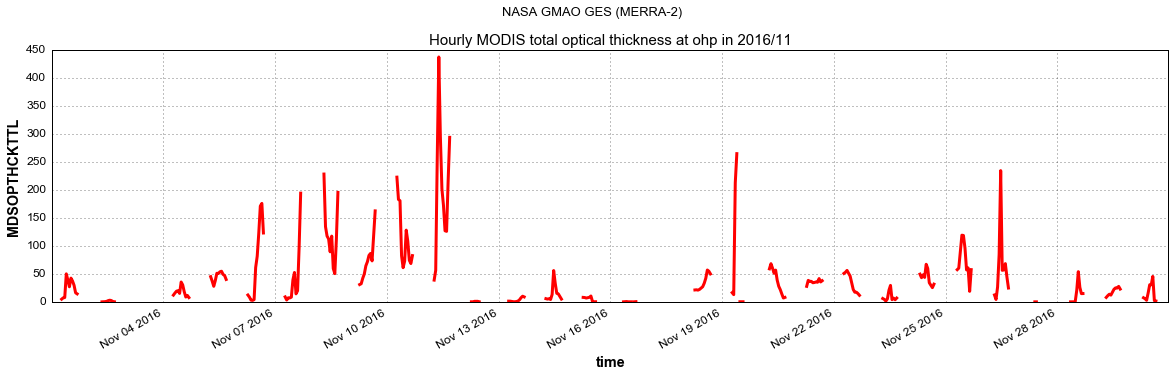

In [43]:
PlotTimeSeries(5,figfile_odtotmean)

## 5) Output

In [44]:
df_tavg1_2d_csp_Nx.index.name='time'
df_tavg1_2d_csp_Nx.describe()

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
count,322.000000,322.000000,322.000000,238.000000,152.000000,274.000000
mean,0.476730,0.154775,0.124564,60.507721,25.340052,45.357014
std,0.380734,0.250914,0.290438,87.549428,39.600259,60.697007
min,0.000000,0.000000,0.000000,0.475137,0.302312,0.304644
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,1.000000,1.524022,2.481977,721.143616,285.966187,437.574768


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [45]:
dataset=df_tavg1_2d_csp_Nx

In [46]:
dataset.index.name='time'

In [47]:
dataset.describe()

,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
count,322.000000,322.000000,322.000000,238.000000,152.000000,274.000000
mean,0.476730,0.154775,0.124564,60.507721,25.340052,45.357014
std,0.380734,0.250914,0.290438,87.549428,39.600259,60.697007
min,0.000000,0.000000,0.000000,0.475137,0.302312,0.304644
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,1.000000,1.524022,2.481977,721.143616,285.966187,437.574768


In [48]:
dataset.head()

,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
time,,,,,,
2016-11-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
dataset.to_csv(pandas_filename)

In [50]:
saved_dataset=pd.read_csv(pandas_filename)

In [51]:
saved_dataset.head()

,time,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
0,2016-11-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-11-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-11-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-11-01 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-11-01 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [52]:
table = Table.from_pandas(saved_dataset)

In [53]:
table

time,ISCCPCLDFRC,MDSH2OPATH,MDSICEPATH,MDSOPTHCKH2O,MDSOPTHCKICE,MDSOPTHCKTTL
str19,float64,float64,float64,float64,float64,float64
2016-11-01 00:30:00,--,--,--,--,--,--
2016-11-01 01:30:00,--,--,--,--,--,--
2016-11-01 02:30:00,--,--,--,--,--,--
2016-11-01 03:30:00,--,--,--,--,--,--
2016-11-01 04:30:00,--,--,--,--,--,--
2016-11-01 05:30:00,--,--,--,--,--,--
2016-11-01 06:30:00,0.278835594654,0.0318594388664,0.0,5.04957008362,--,5.04957008362
2016-11-01 07:30:00,0.461400806904,0.0494255572557,0.0,7.40147304535,--,7.40147304535
2016-11-01 08:30:00,0.450472474098,0.0510864071548,0.0,8.00657844543,--,8.00657844543


In [54]:
table.write(fits_filename,format='fits',overwrite=True)